# Advanced Blackbox usage

(for experienced MyHDL users)

## Top level implementations

A design could be inferred or implemented in various ways, like:

* A simulation only
* An implementation for board X and Architecture A, ...
* Several implementations using different optimization options
* Synthesizing using a different tool than yosys

We may want to keep the different creation and inference variants in one place and not spread across different configuration files. This is where the `@blackbox` concept comes in again.

The example `hello` implementation below acts like a `@block` entity, but has no true hardware interface like a module with I/O ports. Instead, it is an abstract representation of a hardware setup with selectable implementation rules, i.e. functions decorated by `@inference`. The parameter to the `@inference` decorator defines and initializes an implementation context ('design') and is typically derived from `yshelper.Implementation`.

When used to integrated development environments such as ISE, Vivado, Quartus, Diamond, to name some of the larger player's software tools, you might be used to design settings buried in various configuration files.
In the blackbox approach, those settings are buried in the inference rules.

Internally, yosys uses the blackbox model to infer an intermediate representation of the `@blackbox` functional description, exactly like you want it. After all, it is up to building a library and making it portable to different architectures.

## Simulation and Co-Simulation

In some cases, you might want to simulate a full PCB board with externally modelled stimuli and verify one crucial unit of the design in particular. The `@blackbox` can receive a design unit object to be instanced as parameter - this can be a MyHDL design or an externally co-simulated Verilog model resulting from a post-map output. This mapping rule can be embedded into an `@inference` function, returning a simulation object which is again passed as the `unit` parameter in a second pass.

The code below demonstrates how to achieve that.

In [1]:
from myhdl import *

# Period for 25 MHz
CLKHALFPERIOD = 500000 // 25

TOP_UNIT_NAME = "top"

@blackbox
def hello(unit, USE_PLL = True):
    
    clk_in = Signal(bool(0))
    uart_rxd, uart_txd = [ Signal(bool(1)) for i in range(2) ]
    led = Signal(modbv()[8:])
    reset_n = ResetSignal(1, 0, True)

    top = unit(clk_in, reset_n, led, USE_PLL)
 
    def convert(design, top_name, create_trace = False):
        top.convert("yosys_module", design, trace=create_trace)
        # design.run("read_verilog verilog/bram.v")
        design.finalize(top_name)

        
    @inference(MyImpl)
    def hw_impl(design, top_name):
        "This implements and synthesizes the design"
        convert(design, top_name)

        print("\033[7;35mDUMMY HARDWARE IMPLEMENTATION\033[0m")
        # Here we would synthesize and map for a specific architecture
        design.run("hierarchy -check; opt; check")
  
        return design    

    @inference(MySim)
    def sim(design, top_name):
        "This creates a simulation object from a component inside this blackbox"
        convert(design, top_name)

        print("DUMMY SIMULATION")
        tb = "### Simulation object ###"
        # Here we would create the synthesis commands
  
        return tb    

    # Simulation part:
    @instance
    def startup():
        "Reset generator"
        reset_n.next = False
        yield delay(10 * CLKHALFPERIOD)
        reset_n.next = True
    
    @always(delay(CLKHALFPERIOD))
    def clkgen():
        "Clock generator"
        clk_in.next = not clk_in
    
    
    return instances(), hw_impl, sim

The default implementation from the yshelper module is the `Implementation` class as shown below. It creates a yosys design context by default.

In [2]:
from myhdl.conversion.yshelper import Design

class Implementation:
    """The board supply class provides only a base method to create a
yosys design. Typically, one derives from it and inserts own initialization"""
    def __init__(self):
        print("Implementation:", self.__doc__)
    def instance(self, name):
        design = Design(name)
        return design


We can derive specific initialization rules from this class:

In [3]:
class MyImpl(Implementation):
    def __init__(self):
        print("\033[7;36mMy HW implementation\033[0m")

class MySim(Implementation):
    def __init__(self):
        print("Initialize simulation")   

### The top level unit

The block below is a dummy top level unit, which is passed to the `hello` black box from above as implementation selection.

In [4]:
from lfsr8 import lfsr8

@block
def dummy(clk, reset_n, led, USE_PLL):
    
    reset = ResetSignal(0, 1, True)
    dout = Signal(intbv()[8:])
    
    if USE_PLL:
        print("Using PLL: Dummy")

    lfsr_inst = lfsr8(clk, True, reset, 0, dout)
        
    @always_comb
    def assign():
        reset.next = not reset_n
        led.next = dout
        
    return instances()

An `@inference` function is passed the `design` context and the `top_name` identifier when calling the `.implement()` member function (see below)

We choose the hardware implementation rule:

In [5]:
impl = hello(dummy)
design = impl.implement("hw_impl", TOP_UNIT_NAME)

Using PLL: Dummy
SYNTHESIS: Wrapping for inference: MyImpl()
SYNTHESIS: Wrapping for inference: MySim()
My HW implementation
SYNTHESIS: Implementing unit 'hw_impl'
Using PLL: Dummy
CREATE Module: 'lfsr8_0'
Adding module with name: lfsr8_1_c1_1_c0_8
CONVERT_RTL tree >>>>>> 'DUMMY_LFSR8_0_WORKER' 
TIE OTHER: /home/pyosys/src/myhdl/myhdl-local/example/ipynb/lfsr8.py:31 v
CONVERT_RTL tree >>>>>> 'DUMMY_LFSR8_0_ASSIGN' 
DONE instancing submodules
CREATE Module: 'dummy'
Adding module with name: dummy_1_1_8_c1
CONVERT_RTL tree >>>>>> 'DUMMY_ASSIGN' 
++++++++ lfsr8_0: lfsr8_1_c1_1_c0_8  ++++++++
DONE instancing submodules
DUMMY HARDWARE IMPLEMENTATION


But we can also extract a simulation object out of the `hello` blackbox:

In [6]:
sim = hello(dummy)
tb = sim.implement("sim", TOP_UNIT_NAME + "_sim")
print("This is the simulation object:", tb)

Using PLL: Dummy
SYNTHESIS: Wrapping for inference: MyImpl()
SYNTHESIS: Wrapping for inference: MySim()
Initialize simulation
SYNTHESIS: Implementing unit 'sim'
Using PLL: Dummy
CREATE Module: 'lfsr8_0_0'
Adding module with name: lfsr8_1_c1_1_c0_8
CONVERT_RTL tree >>>>>> 'DUMMY_LFSR8_0_0_WORKER' 
TIE OTHER: /home/pyosys/src/myhdl/myhdl-local/example/ipynb/lfsr8.py:31 v
CONVERT_RTL tree >>>>>> 'DUMMY_LFSR8_0_0_ASSIGN' 
DONE instancing submodules
CREATE Module: 'dummy'
Adding module with name: dummy_1_1_8_c1
CONVERT_RTL tree >>>>>> 'DUMMY_ASSIGN' 
++++++++ lfsr8_0_0: lfsr8_1_c1_1_c0_8  ++++++++
DONE instancing submodules
DUMMY SIMULATION
This is the simulation object: ### Simulation object ###


### RTL display

We display the 'synthesized' design for reference:

Generating RTL image...
Display...


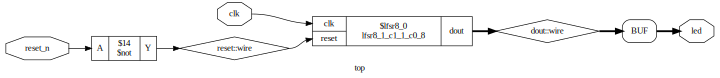

In [7]:
from ys_aux import to_svg
display(to_svg(design, TOP_UNIT_NAME, 100))